# Task 2

Task 2: You are free to find and define a problem (apply the discovery and define phases first, from the UK Design Council Double Diamond, 3.007 Design Thinking and Innovation) of your interest related to COVID-19. The problem can be modelled either using Linear Regression (or Multiple Linear Regression) or Logistic Regression, which means you can work with either continuous numerical data or classification.

The following technical/tool constraint applies: you are NOT allowed to use Neural Networks or other Machine Learning models. You must use Python and Jupyter Notebook.

In general, you may want to consider performing the following steps:
- Find an interesting problem which you want to solve either using **Linear Regression or Classification** (please check with your instructors first on whether the problem makes sense).
- Find a **dataset** to build your model. For example, you can use Kaggle (https://www.kaggle.com/datasets) to find suitable datasets.
- Use **plots** to visualize and understand your data.
- Create **training and test** data sets.
- Build your model.
- Choose an **appropriate metric** to evaluate your model (you may use the same metric as the one used in Task 1).
- Improve your model.

Problem: predict gold prices given covid
Effect of covid on economy

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load data 
We use data from [Yahoo Finance](https://finance.yahoo.com/quote/GLD/history?period1=1479859200&period2=1637625600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) 

In [266]:
df_gold_all = pd.read_csv('GLD.csv')
df = pd.read_csv('covid_data.csv')

# display(df_gold)
# display(df)


## Clean data

In [267]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set

df_subset = df.loc[((df['location']=='United States')| (df['location']=='China') | (df['location']=='Japan') | (df['location']=='Hong Kong') | (df['location']=='United Kingdom') | 
(df['location']=='Canada') | (df['location']=='India') | (df['location']=='Saudi Arabia') | (df['location']=='France') | (df['location']=='Germany') | 
(df['location']=='South Korea') | (df['location']=='Switzerland') | (df['location']=='Australia') | (df['location']=='Netherlands') |  
(df['location']=='Iran')| (df['location']=='Sweden')| (df['location']=='Brazil')| (df['location']=='Spain')|(df['location']=='Russia') |(df['location']=='Singapore')) ,:]

# & ((df['date']> '2021-01-01') & (df['date']< '2021-11-17'))
#'population_density','handwashing_facilities','extreme_poverty','gdp_per_capita',
# (df['location']=='Bulgaria') | (df['location']=='Croatia') | (df['location']=='Cyprus') | (df['location']=='Czech Republic') | 
# (df['location']=='Latvia') | (df['location']=='Lithuania') | (df['location']=='Luxembourg') | 
# (df['location']=='Malta') | 
# (df['location']=='Romania')| 
# (df['location']=='Slovakia')|

In [268]:
df_covid=df_subset.fillna(0)
# display(df_covid.index)

In [269]:
df_covid['Week']=pd.to_datetime(df_covid['date'])
# print(df_covid)
df_covid=df_covid.groupby(pd.Grouper(key='Week', freq="W-MON")).mean()
df_covid=df_covid.iloc[:95,:]
display(df_covid)

# print(df_covid.index)
print(df_covid.shape)

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
Week,,,,,,,,,,,,,,,,,,,,,
2020-01-27,1.943864e+02,53.477273,0.000000,5.477273,1.477273,0.000000,0.297568,0.089614,0.000000,0.003795,...,10.481818,29.765909,0.000000,5.987500,82.039091,0.904091,-305.222727,-0.297045,-0.155000,-2.225662
2020-02-03,8.796517e+02,190.157303,110.916562,19.022472,3.853933,2.303360,0.990517,0.180955,0.116865,0.013157,...,13.595506,28.424719,3.345506,5.018315,81.071573,0.895573,-441.528090,-0.309101,-0.233933,-4.130858
2020-02-10,2.246571e+03,216.228571,214.404114,48.828571,5.590476,4.672114,2.302438,0.231838,0.208505,0.042562,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-305.123810,-0.302000,-0.366381,-3.752702
2020-02-17,4.079381e+03,287.304762,261.829962,99.238095,8.133333,7.201362,4.236981,0.286857,0.276352,0.078219,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-364.008571,-0.312762,-0.379810,-4.554481
2020-02-24,4.821793e+03,52.171171,137.436297,145.504505,6.774775,7.348811,5.446937,0.228414,0.204117,0.124514,...,13.816216,28.358559,3.755405,4.587568,80.557748,0.886108,-436.255856,-0.362793,-0.509279,-5.690573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-18,7.391052e+06,11407.221429,11276.902071,133357.435714,191.471429,187.549007,60806.002014,133.272157,128.602293,1009.321393,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3943.779286,0.581857,0.592357,73.788620
2021-10-25,7.471264e+06,11422.700000,11458.869343,134702.250000,193.078571,192.116371,61804.031629,146.637193,142.575657,1018.136736,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3991.925714,0.582000,0.580643,74.556017
2021-11-01,7.552099e+06,11694.685714,11547.889779,136051.192857,190.264286,192.706121,62873.409793,156.264857,152.768264,1027.122921,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,9508.196429,0.647500,0.983643,97.183008


(95, 62)


In [270]:
# Clean Up of Gold Data frame
# change to standard date 

df_gold_all = pd.read_csv('GLD.csv')

# change gold date range to same range as covid date range
df_gold=df_gold_all.copy()
df_gold=df_gold.loc[((df_gold['Date']> '2020-01-26') & (df_gold['Date']< '2021-11-17')) ,:]

# change the date column to DateTime Index
df_gold['Date'] = pd.to_datetime(df_gold['Date']).dt.date

# pd.set_option('display.max_rows', None)
# display(df_gold)
# print(pd.options.display.max_rows)
# pd.reset_option('display.max_rows')
# print(pd.options.display.max_rows)
display(df_gold)
print(df_gold.shape)

    

,Date,Open,High,Low,Close,Adj Close,Volume
166,2020-01-27,149.240005,149.679993,147.529999,149.330002,149.330002,46452100.0
167,2020-02-03,148.660004,148.779999,145.800003,147.789993,147.789993,36990700.0
168,2020-02-10,148.210007,149.130005,147.009995,149.000000,149.000000,28441100.0
169,2020-02-17,149.880005,155.220001,149.470001,154.699997,154.699997,45596500.0
170,2020-02-24,158.500000,158.529999,147.050003,148.380005,148.380005,143753100.0
...,...,...,...,...,...,...,...
256,2021-10-18,165.419998,169.539993,164.809998,167.770004,167.770004,30756400.0
257,2021-10-25,168.660004,169.250000,165.639999,166.649994,166.649994,31895900.0
258,2021-11-01,167.380005,169.940002,164.380005,169.839996,169.839996,33813300.0
259,2021-11-08,170.429993,174.669998,170.059998,174.449997,174.449997,36061400.0


(95, 7)


In [271]:
df_covid=df_covid.reset_index()
# display(df_covid)
df_gold=df_gold.reset_index()
# display(df_gold)
frames=[df_gold,df_covid]
df_all = pd.concat(frames,axis=1)
display(df_all)
df_all.drop(['index','Week'], axis=1, inplace=True)
display(df_all)

,index,Date,Open,High,Low,Close,Adj Close,Volume,Week,total_cases,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,166,2020-01-27,149.240005,149.679993,147.529999,149.330002,149.330002,46452100.0,2020-01-27,1.943864e+02,...,10.481818,29.765909,0.000000,5.987500,82.039091,0.904091,-305.222727,-0.297045,-0.155000,-2.225662
1,167,2020-02-03,148.660004,148.779999,145.800003,147.789993,147.789993,36990700.0,2020-02-03,8.796517e+02,...,13.595506,28.424719,3.345506,5.018315,81.071573,0.895573,-441.528090,-0.309101,-0.233933,-4.130858
2,168,2020-02-10,148.210007,149.130005,147.009995,149.000000,149.000000,28441100.0,2020-02-10,2.246571e+03,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-305.123810,-0.302000,-0.366381,-3.752702
3,169,2020-02-17,149.880005,155.220001,149.470001,154.699997,154.699997,45596500.0,2020-02-17,4.079381e+03,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-364.008571,-0.312762,-0.379810,-4.554481
4,170,2020-02-24,158.500000,158.529999,147.050003,148.380005,148.380005,143753100.0,2020-02-24,4.821793e+03,...,13.816216,28.358559,3.755405,4.587568,80.557748,0.886108,-436.255856,-0.362793,-0.509279,-5.690573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,256,2021-10-18,165.419998,169.539993,164.809998,167.770004,167.770004,30756400.0,2021-10-18,7.391052e+06,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3943.779286,0.581857,0.592357,73.788620
91,257,2021-10-25,168.660004,169.250000,165.639999,166.649994,166.649994,31895900.0,2021-10-25,7.471264e+06,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3991.925714,0.582000,0.580643,74.556017
92,258,2021-11-01,167.380005,169.940002,164.380005,169.839996,169.839996,33813300.0,2021-11-01,7.552099e+06,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,9508.196429,0.647500,0.983643,97.183008
93,259,2021-11-08,170.429993,174.669998,170.059998,174.449997,174.449997,36061400.0,2021-11-08,7.634196e+06,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,1962.652143,0.305929,0.394786,30.333411


,Date,Open,High,Low,Close,Adj Close,Volume,total_cases,new_cases,new_cases_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,2020-01-27,149.240005,149.679993,147.529999,149.330002,149.330002,46452100.0,1.943864e+02,53.477273,0.000000,...,10.481818,29.765909,0.000000,5.987500,82.039091,0.904091,-305.222727,-0.297045,-0.155000,-2.225662
1,2020-02-03,148.660004,148.779999,145.800003,147.789993,147.789993,36990700.0,8.796517e+02,190.157303,110.916562,...,13.595506,28.424719,3.345506,5.018315,81.071573,0.895573,-441.528090,-0.309101,-0.233933,-4.130858
2,2020-02-10,148.210007,149.130005,147.009995,149.000000,149.000000,28441100.0,2.246571e+03,216.228571,214.404114,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-305.123810,-0.302000,-0.366381,-3.752702
3,2020-02-17,149.880005,155.220001,149.470001,154.699997,154.699997,45596500.0,4.079381e+03,287.304762,261.829962,...,14.560000,28.773333,3.970000,4.764000,80.779333,0.892000,-364.008571,-0.312762,-0.379810,-4.554481
4,2020-02-24,158.500000,158.529999,147.050003,148.380005,148.380005,143753100.0,4.821793e+03,52.171171,137.436297,...,13.816216,28.358559,3.755405,4.587568,80.557748,0.886108,-436.255856,-0.362793,-0.509279,-5.690573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-10-18,165.419998,169.539993,164.809998,167.770004,167.770004,30756400.0,7.391052e+06,11407.221429,11276.902071,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3943.779286,0.581857,0.592357,73.788620
91,2021-10-25,168.660004,169.250000,165.639999,166.649994,166.649994,31895900.0,7.471264e+06,11422.700000,11458.869343,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,3991.925714,0.582000,0.580643,74.556017
92,2021-11-01,167.380005,169.940002,164.380005,169.839996,169.839996,33813300.0,7.552099e+06,11694.685714,11547.889779,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,9508.196429,0.647500,0.983643,97.183008
93,2021-11-08,170.429993,174.669998,170.059998,174.449997,174.449997,36061400.0,7.634196e+06,11915.964286,11728.156171,...,13.905000,27.610000,2.977500,4.285500,80.272000,0.884050,1962.652143,0.305929,0.394786,30.333411


In [272]:
# Clean covid data by selecting only the relevant columns
# split data into numerical and categorical set so that we can normalize the numerical set
columns_cat=['Date']
columns_num=['new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients','Open','High','Low','Close','Adj Close','Volume']

df_cat = df_all.loc[:,columns_cat]

df_num = df_all.loc[:,columns_num]

# display(df_num)

def normalize_minmax(dfin):
    df_copy=dfin.copy()
    min_v=dfin.min(axis=0)
    max_v=dfin.max(axis=0)
    dfout=(df_copy-min_v)/(max_v-min_v)
    return dfout

df_num_norm = normalize_minmax(df_num)
stats = df_num_norm.describe()
# display(stats)

frames=[df_cat , df_num_norm]
result = pd.concat(frames,axis=1)
df_covid=result.fillna(0)
# display(df_covid.index)

,new_deaths,new_cases,stringency_index,total_tests,total_vaccinations,reproduction_rate,hospital_beds_per_thousand,hosp_patients_per_million,hosp_patients,icu_patients_per_million,icu_patients,Open,High,Low,Close,Adj Close,Volume
0,1.477273,53.477273,14.100909,3.568182e+00,0.000000e+00,0.375000,5.987500,0.002000,0.136364,0.000000,0.000000,149.240005,149.679993,147.529999,149.330002,149.330002,46452100.0
1,3.853933,190.157303,16.485618,5.439326e+01,0.000000e+00,0.223483,5.018315,0.005494,0.370787,0.001517,0.101124,148.660004,148.779999,145.800003,147.789993,147.789993,36990700.0
2,5.590476,216.228571,19.572857,9.919048e+01,0.000000e+00,0.116381,4.764000,0.008752,0.590476,0.000857,0.057143,148.210007,149.130005,147.009995,149.000000,149.000000,28441100.0
3,8.133333,287.304762,19.978476,4.411333e+02,0.000000e+00,0.085524,4.764000,0.005219,0.352381,0.000286,0.019048,149.880005,155.220001,149.470001,154.699997,154.699997,45596500.0
4,6.774775,52.171171,20.183423,1.102829e+03,0.000000e+00,0.241171,4.587568,0.002270,0.153153,0.000000,0.000000,158.500000,158.529999,147.050003,148.380005,148.380005,143753100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,191.471429,11407.221429,53.169429,8.688063e+07,2.274649e+08,0.938143,4.285500,26.957671,3599.057143,7.257300,1079.514286,165.419998,169.539993,164.809998,167.770004,167.770004,30756400.0
91,193.078571,11422.700000,52.262714,8.994827e+07,2.343906e+08,0.984000,4.285500,27.200257,3362.207143,7.102771,1007.642857,168.660004,169.250000,165.639999,166.649994,166.649994,31895900.0
92,190.264286,11694.685714,47.827643,8.947385e+07,2.331194e+08,1.019857,4.285500,27.753571,3198.550000,7.029236,917.557143,167.380005,169.940002,164.380005,169.839996,169.839996,33813300.0
93,176.392857,11915.964286,42.060286,9.215567e+07,2.337482e+08,1.017429,4.285500,27.349979,3034.028571,6.782521,830.307143,170.429993,174.669998,170.059998,174.449997,174.449997,36061400.0


In [275]:
display(df_covid)

,Date,new_deaths,new_cases,stringency_index,total_tests,total_vaccinations,reproduction_rate,hospital_beds_per_thousand,hosp_patients_per_million,hosp_patients,icu_patients_per_million,icu_patients,Open,High,Low,Close,Adj Close,Volume
0,2020-01-27,0.000000,0.000044,0.000000,0.000000e+00,0.000000,0.162629,1.000000,0.000000,0.000000,0.000000,0.000000,0.217748,0.072124,0.237313,0.181854,0.181854,0.165056
1,2020-02-03,0.005776,0.004661,0.039136,5.515133e-07,0.000000,0.077506,0.430561,0.000030,0.000022,0.000071,0.000046,0.206935,0.053472,0.201331,0.151479,0.151479,0.083867
2,2020-02-10,0.009996,0.005542,0.089802,1.037617e-06,0.000000,0.017336,0.281140,0.000058,0.000043,0.000040,0.000026,0.198546,0.060726,0.226497,0.175345,0.175345,0.010502
3,2020-02-17,0.016176,0.007943,0.096459,4.748109e-06,0.000000,0.000000,0.281140,0.000028,0.000020,0.000013,0.000009,0.229679,0.186943,0.277662,0.287771,0.287771,0.157714
4,2020-02-24,0.012874,0.000000,0.099823,1.192830e-05,0.000000,0.087444,0.177478,0.000002,0.000002,0.000000,0.000000,0.390380,0.255544,0.227330,0.163116,0.163116,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-10-18,0.461726,0.383587,0.641170,9.427594e-01,0.913944,0.479006,0.000000,0.231596,0.338082,0.340481,0.487625,0.519389,0.483730,0.596714,0.545562,0.545562,0.030370
91,2021-10-25,0.465631,0.384110,0.626290,9.760471e-01,0.941771,0.504769,0.000000,0.233680,0.315833,0.333231,0.455160,0.579791,0.477720,0.613977,0.523471,0.523471,0.040148
92,2021-11-01,0.458792,0.393298,0.553504,9.708990e-01,0.936664,0.524913,0.000000,0.238434,0.300459,0.329781,0.414468,0.555929,0.492021,0.587771,0.586390,0.586390,0.056601
93,2021-11-08,0.425082,0.400773,0.458853,1.000000e+00,0.939190,0.523549,0.000000,0.234967,0.285003,0.318206,0.375056,0.612789,0.590052,0.705907,0.677318,0.677318,0.075892


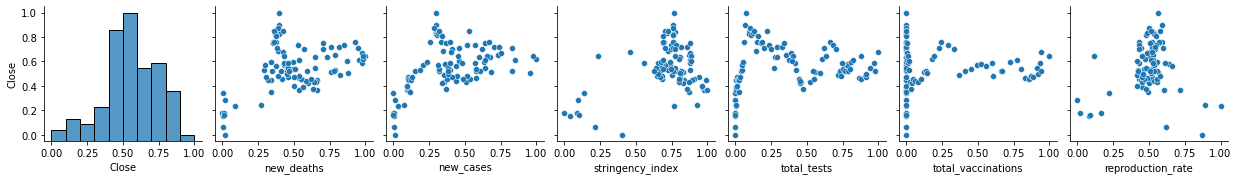

In [276]:
myplot = sns.pairplot(data=df_covid, x_vars=['Close','new_deaths', 'new_cases',
         'stringency_index','total_tests','total_vaccinations',
         'reproduction_rate'],y_vars=['Close'])

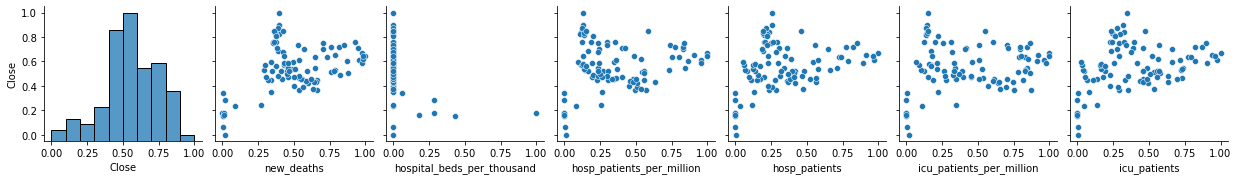

In [277]:
myplot = sns.pairplot(data=df_covid, x_vars=['Close','new_deaths','hospital_beds_per_thousand','hosp_patients_per_million',
         'hosp_patients','icu_patients_per_million','icu_patients'],y_vars=['Close'])